<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


In [368]:
# import piplite
# await piplite.install(['numpy'])
# await piplite.install(['pandas'])
# await piplite.install(['seaborn'])

We will import the following libraries for the lab


In [369]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [370]:
# Configure pandas to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Configure pandas to show float to .3f
pd.options.display.float_format = '{:.3f}'.format

This function is to plot the confusion matrix.


In [371]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

## Load the dataframe


Load the data


In [372]:
# Load the datasets

# data = pd.read_csv(
#     "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
# )

# X = pd.read_csv(
#     "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv"
# )

# # What I would personally additionally do but the course does not ask for it
# landing_pad_cols = [col for col in X.columns if col.startswith("LandingPad")]
# X = X.rename(columns={col: f"L_Pad_{i}" for i, col in enumerate(landing_pad_cols)})
# landing_site_cols = [col for col in X.columns if col.startswith("LaunchSite")]
# X = X.rename(columns={col: f"L_Site_{i}" for i, col in enumerate(landing_site_cols)})
# data.to_csv("spaceX_part2_data.csv", index=False)
# X.to_csv("spaceX_part3_data.csv", index=False)

In [ ]:
# USE THIS IF YOU WANT TO USE THE LOCAL FILES
data = pd.read_csv("spaceX_part2_data.csv")
X = pd.read_csv("spaceX_part3_data.csv")

### Additional data wrangling that the course does not ask for

In [374]:
'''The X dataframe has no date - it may be useful to add a feature that represents the time since the first flight of the booster - this could be a proxy for technical improvements in the booster over time - we will add this feature to the X dataframe'''
data['Date'] = pd.to_datetime(data['Date'])
first_flight = data['Date'].min()
X['TimeSinceFirstFlight'] = (data['Date'] - first_flight).dt.days

'''It does not make sense to use the serial number as a feature as it is a unique identifier for each booster - if it has any contribution to the model it is again only as a proxy for progress'''
cols_to_drop = [col for col in X.columns if col.startswith('Serial')]
X = X.drop(cols_to_drop, axis=1)


'''Looking at the "Flights" column and compare to the "ReusedCount" column - the data is not consistent - I believe ReusedCount should simply be Flights - 1 - absent any explanation of this we will drop the "Flights" column'''
X = X.drop('Flights', axis=1)

'''The dataset has a number of redundant columns for binary features, we will drop the redundant columns'''
X = X.drop(['Reused_False', 'GridFins_False', 'Legs_False'], axis=1)

'''Block is a categorical variable that is SpaceX terminology akin to a version for the variants of booster - but block 1 is used for both v1.0 and v 1.1 - ideally we would have a version column that would be a numerical representation of the version of the booster - but we do not have this information - so we will one-hot encode the block column'''
X = pd.get_dummies(X, columns=['Block'])

## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [377]:
Y = data['Class'].to_numpy()

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [411]:
# students get this 
transform = preprocessing.StandardScaler().fit(X)

# From here on X is a numpy array not a pandas dataframe
X_cols = X.columns
X = transform.transform(X)

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [381]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

we can see we only have 18 test samples.


In [382]:
Y_test.shape

(18,)

# BASELINE HEURISTIC

A reasonable person might think that to predict whether a Booster was successfully recovered by SpaceX, the most important think to know would probably be - "Did SpaceX ever intend to recover the booster?".  This isn't a datapoint that we ever captured or thought about capturing - although we could have from web-scraping.

In our data-set, the closest proxy for "did they intend to recover" is whether the booster had legs (as aside a few notable examples Space X has pursued land recovery of the booster).

Looking at this simple split of the classes we see:

In [383]:
data.groupby(["Legs", "Class"])['FlightNumber'].count()

Legs   Class
False  0        18
       1         1
True   0        12
       1        59
Name: FlightNumber, dtype: int64

The is one single case of "Class=1" but without legs - this was a soft ocean landing was actual a failure as they were not able to recover the booster.

In [384]:
data[(data['Class'] == 1) & (data['Legs'] == 0)]

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
42,43,2017-12-23,Falcon 9,9600.000,PO,VAFB SLC 4E,True Ocean,2,True,True,False,NaN,3.000,1,B1036,-120.611,34.632,1


We might also make the default assumption that as this dataset includes all the early launches, that there was a natural learning curve and SpaceX failure rate went they intended to recover got better with launch experience.

We can see this trend.

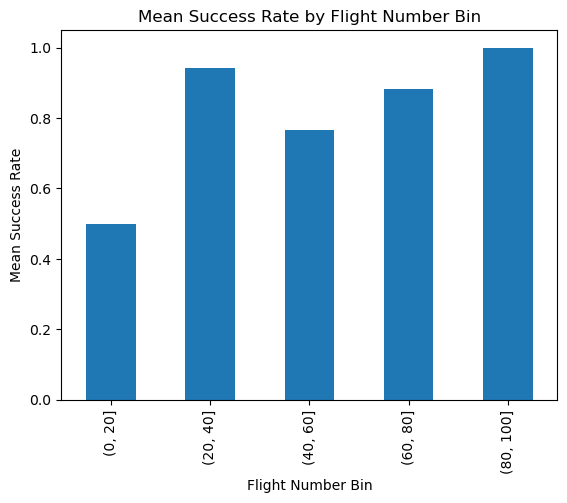

In [385]:
data["FNBin"] = pd.cut(data["FlightNumber"], bins=list(range(0, 120, 20)))

_ = data[data["Legs"] == True].groupby("FNBin")["Class"].mean().plot.bar(
    x="FNBin", y="Class", title="Mean Success Rate by Flight Number Bin",
    xlabel="Flight Number Bin", ylabel="Mean Success Rate"
)

From this it seems that there is a marked improvement after flight 20.

In [386]:
# Heuristic for failure rates
p_success_legs_less_20 = data[(data["FlightNumber"] < 20) & (data["Legs"] == True)]["Class"].mean()

p_success_legs_greater_20 = data[(data["FlightNumber"] >= 20) & (data["Legs"] == True)]["Class"].mean()

print(f"Success rate for legs and flight number less than 20: {p_success_legs_less_20:.1%}")
print(f"Success rate for legs and flight number greater than 20: {p_success_legs_greater_20:.1%}")

Success rate for legs and flight number less than 20: 44.4%
Success rate for legs and flight number greater than 20: 88.7%


If we using this in a very simple heuristic we might say:
- If no legs - assume class = 0 (Failure)
- If legs after flight 20 - assume Class=1 (Success) as highly probable
- If legs prior to flight 20 its pretty much a toss up = just randomly guess

In [387]:
def predict(row):
    if row["Legs"] == True:
        if row["FlightNumber"] >= 20:
            return 1
        else:
            return int(np.random.rand())
    else:
        return 0

In [388]:
# Heuristic predictions
len_data = len(data)
n = 18

scores = []
for _ in range(100):
    sample_df = data.sample(n=n, replace=False)
    sample_df["Predicted"] = sample_df.apply(predict, axis=1)
    score = (sample_df["Class"] == sample_df["Predicted"]).mean()
    scores.append(score)

# # Baseline heuristic performance
accuracy = sum(scores) / 100
print(f"Accuracy: {accuracy:.1%}")
print(f"Worst case: {min(scores):.1%}")
print(f"Best case: {max(scores):.1%}")

Accuracy: 86.4%
Worst case: 72.2%
Best case: 100.0%


The above heuristic is a baseline for considering accuracy of models - using this we would be correct ~86% of the time.

Let's store this baseline performance.

In [389]:
MODEL_SCORES = {
    "Baseline Heuristic": accuracy,
}

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [390]:
'''Using slightly different parameters than the course as 'lbfgs' does not support l1 penalty - and want to try lasso regularization to drive some coefficients to zero as I suspect some features are not useful'''
parameters ={'C':[0.01, 0.1, 1],
             'penalty':['l1'],
             'solver':['liblinear']}

lr_est = LogisticRegression(random_state=0)

logreg_cv= GridSearchCV(lr_est, param_grid=parameters, cv=10)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l1'],
                         'solver': ['liblinear']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [391]:
print("CV hyperparameters:(best parameters) ", logreg_cv.best_params_)
print(f"Training Accuracy: {logreg_cv.best_score_:.1%}\n")

CV hyperparameters:(best parameters)  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Training Accuracy: 84.6%



## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [392]:
# Test score
logreg_test_score = logreg_cv.score(X_test, Y_test)
print(f"\nTest score: {logreg_test_score:.1%}")

MODEL_SCORES["Logistic Regression"] = logreg_test_score


Test score: 94.4%


We can see that this performance beats our baseline heuristic.

If we look at the coefficients not driven to near zero via l1 regularization we see the features most importance to the model.

In [413]:
features = zip(X_cols, logreg_cv.best_estimator_.coef_[0])
features = sorted(features, key=lambda x: abs(x[1]), reverse=True)
for feature, coef in features:
    if abs(coef) > 0.1:
        print(f"{feature}: \t{coef:.3f}")

Legs_True: 	1.374
ReusedCount: 	0.896
Orbit_LEO: 	0.582
Block_1.0: 	-0.528
Block_4.0: 	-0.343
Block_2.0: 	0.305
Orbit_ES-L1: 	0.282
L_Site_0: 	-0.208
Block_3.0: 	0.204
Orbit_SO: 	-0.162


As with our simple heuristic the model places most importance on "Legs", but the model has learned the importance of some other features - in particular "ReusedCount" - which makes sense as this is likely also correlated to the "intention" to recover the booster.  Block is in effect booster version - so it would be expected that this would impact the model.

Lets look at the confusion matrix:


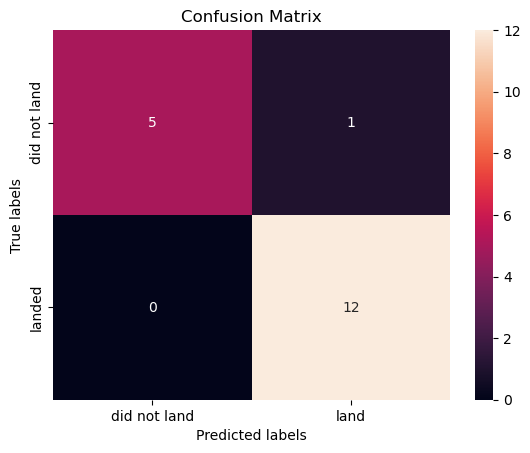

In [394]:
yhat = logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [395]:
# This parameter grid is way too large and will take a long time to run
parameters = {
    'kernel': ['sigmoid'], #('linear','poly', 'rbf', 'sigmoid'),
    'C': np.logspace(-3, 5, 5),
    'gamma':np.logspace(-3, 5, 5)
}

svm = SVC(random_state=0)

In [396]:
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(random_state=0),
             param_grid={'C': array([1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05]),
                         'gamma': array([1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05]),
                         'kernel': ['sigmoid']})

In [397]:
print("Tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("Training accuracy :", svm_cv.best_score_)

Tuned hpyerparameters :(best parameters)  {'C': 0.1, 'gamma': 10.0, 'kernel': 'sigmoid'}
Training accuracy : 0.8625


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [398]:
accuracy = svm_cv.score(X_test, Y_test)
print(f"Test accuracy: {accuracy:.1%}")

MODEL_SCORES["SVM"] = accuracy

Test accuracy: 94.4%


We can plot the confusion matrix


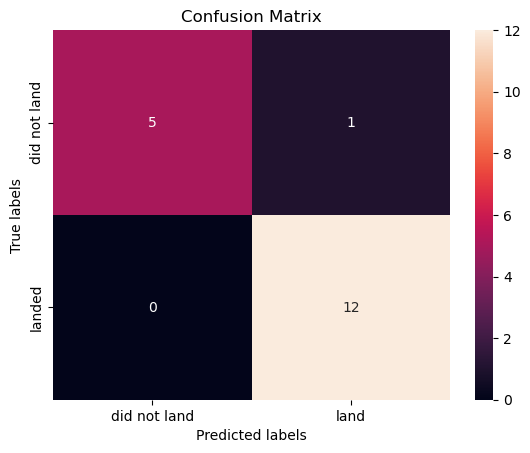

In [399]:
yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [400]:
parameters = {
     'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(2,6)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]
     }

tree = DecisionTreeClassifier(random_state=0)

In [401]:
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [402]:
print("Tuned hyperparameters :(best parameters) ", tree_cv.best_params_)
print(f"Training accuracy: {tree_cv.best_score_:.1%}")

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}
Training accuracy: 87.5%


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [403]:
score = tree_cv.score(X_test, Y_test)
print(f"Test accuracy: {score:.1%}")

MODEL_SCORES["Decision Tree"] = score

Test accuracy: 88.9%


We can plot the confusion matrix


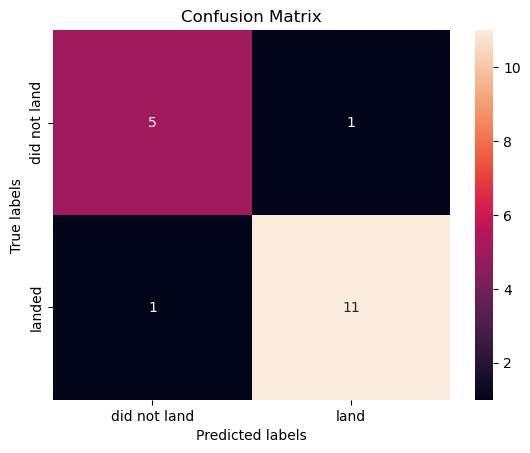

In [404]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [405]:
parameters = {
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1,2]
}

KNN = KNeighborsClassifier()

In [406]:
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [407]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("Training accuracy :", knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 6, 'p': 2}
Training accuracy : 0.8607142857142858


## TASK  11


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [408]:
score = knn_cv.score(X_test, Y_test)
print(f"Test accuracy: {score:.1%}")

MODEL_SCORES["KNN"] = score

Test accuracy: 94.4%


We can plot the confusion matrix


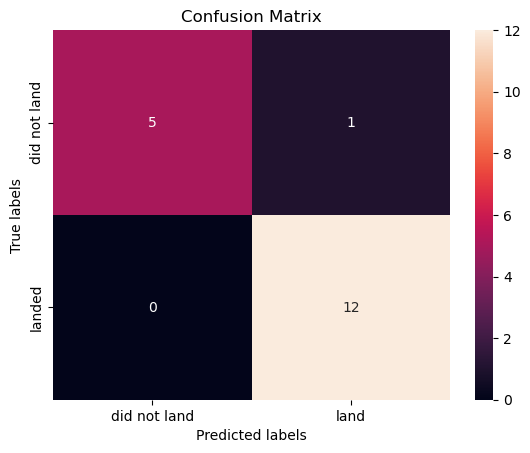

In [409]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)

## TASK  12


Find the method performs best:


In [410]:
for model, score in MODEL_SCORES.items():
    print(f"{model} accuracy: {score:.1%}")

Baseline Heuristic accuracy: 86.4%
Logistic Regression accuracy: 94.4%
SVM accuracy: 94.4%
Decision Tree accuracy: 88.9%
KNN accuracy: 94.4%


From reviewing the various models we can see that all have managed to extract more predictive information from our training data that our simple heuristic.  As would be expected, with the exception of the Decision Tree Classifier, all the other models after suitable tuning have achieved the same approximate test score - as they are different approaches to achieving the same objective (minimising generalized error).

The Decision Tree performed a little worse.  This may be due to the inherent tendancy of trees to over-fit (even when selecting via CV  the hyper-parameter that result in the best generalized performance).  If the dataset was larger ensemble techniques - such as Random Forest - may have been appropriate to improve test performance, but at the cost of increased computational effort.

## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork865-2023-01-01)


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
